# 모델 소개

In [1]:
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

from konlpy.tag import Okt  # 품사 태깅
from gensim.models import Word2Vec
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import re
import joblib
import io
from itertools import chain
from collections import Counter

# 맞춤법검사 PLM 관련
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, pipeline

# 전처리 관련
from pykospacing import Spacing # 띄어쓰기 교정
from soynlp.normalizer import emoticon_normalize  # 반복 단어 제거
from konlpy.tag import Okt  # 품사 태깅

# 모델 부분 관련
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import *

In [2]:
import sentencepiece
# 맞춤법 교정 모델 text2text GAN (Pretrained Language Model : PLM 모델 활용)
corrector_model = T5ForConditionalGeneration.from_pretrained('j5ng/et5-typos-corrector')
corrector_tokenizer = T5Tokenizer.from_pretrained('j5ng/et5-typos-corrector')

typos_corrector = pipeline(
    "text2text-generation",
    model=corrector_model,
    tokenizer=corrector_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    framework="pt",
)

# 맞춤법 교정
def spelling_check(text):
    """
    맞춤법 교정
    """
    # 텍스트를 문장 단위로 분할합니다.
    parts_of_text = re.split(r'([,.!?])', text)  # 구분자를 유지하기 위해 그룹화

    correct_text = []

    for i in range(0, len(parts_of_text), 2):
        sentence = parts_of_text[i]
        if sentence.strip():  # 문장이 비어있지 않은 경우에만 처리
            # 맞춤법 교정을 적용합니다.
            corrected = typos_corrector("맞춤법을 고쳐주세요: " + sentence,
                                        max_length=128,
                                        num_beams=5,
                                        early_stopping=True)[0]['generated_text']
            corrected = corrected.rstrip('.,!?')
            correct_text.append(corrected)
        
        # 구분자(특수문자)를 다시 추가합니다.
        if i + 1 < len(parts_of_text):
            correct_text.append(parts_of_text[i + 1])

    return ''.join(correct_text)

# 띄어쓰기 처리
def spacing_processing(text):
    """
    띄어쓰기 처리
    """

    spacing = Spacing()
    text = spacing(text)
    return text

# 반복 문자 처리
def repetitive_character_processing(text):
    """
    반복 문자 처리
    """
    text = emoticon_normalize(text, num_repeats=2)
    return text


# 사용자 입력 데이터 처리
def input_process_text(text):
    text = repetitive_character_processing(text)
    text = spacing_processing(text)
    text = spelling_check(text)
    return text

# 한글이 아닌 특수문자 제거
def extract_keywords(text):

    # Konlpy
    okt = Okt()

    # 불용어처리
    stopwords = ['한테', '모레', '로', '나', '있다', '이미', '많이', '하다', '것', '종일', '매우', '하며', '있는', '곳', '저', '그것', '내일', '과', '그렇다면', '너',
                '누구의', '언제', '있고', '에서', '무엇', '정말', '와', '혹은', '이따가', '가', '그녀', '어제', '진짜', '실제로', '무슨', '만일', '가장', '등', '몹시',
                '께', '하지만', '을', '아주', '이', '누구', '그리고', '에게서', '잠깐', '모두', '에', '으로', '위한', '너무', '여기', '어디', '그러나', '의', '계속', '누가',
                '또는', '한참', '하고', '한테서', '우리', '이것', '까지', '조금', '그', '오늘', '적게', '그렇지만', '만약', '수', '를', '부터', '무엇이', '그래서', '는',
                '및', '방금', '은', '등등', '그런데', '거기', '어떤', '에게', '도', '벌써', '당신', '지금', '다', '저것', '할', '그냥', '사실', '어느', '얼마나', '읽을',
                '잠시', '어떻게', '한', '금방', '저기', '가득', '추천', '알려줘', '해줘', '어린이', '아이', '먹다', '맛', '가다', '오다', '자다', '같다', '더', '넘다', '또', 
                '이다', '아쉽다', '바', '꼭', '보다', '되어다', '나오다', '요', '들다', '처', '다음', '때', '되다', '거', '싶다', '점', '주다', '리지', '널', '크리스', '크림', 
                '피', '드', '안', '역시', '받다', '글레이', '좀', '꾸다', '지점', '해', '덮다', '집', '굿', '시', '비', '없다', '나다', '생기다', '바로', '못', '날']
    parts_of_text = re.split(r'([,.!?])', text)  # 구분자를 유지하기 위해 그룹화
    processed_tokens = []

    for part in parts_of_text:
        tokens = okt.pos(part.strip(), stem=True)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            # 명사, 형용사, 동사인 경우에만 처리
            if token[1] in ['Noun', 'Adjective', 'Verb'] and token[0] not in stopwords:
                processed_tokens.append(token[0])

                # 명사이거나 형용사인 경우 -> 명사 + 명사 : 복합명사 ex) 숲체험 / 형용사 + 명사 : 꾸며주는 명사 ex) 친절한 직원
                if token[1] in ['Noun', 'Adjective']:
                    # 다음 토큰도 명사이고, 두 토큰을 합쳐서 하나의 토큰으로 처리
                    if i < len(tokens) - 1 and tokens[i + 1][1] in ['Noun'] and tokens[i + 1][0] not in stopwords:
                        combined_token = token[0] + tokens[i + 1][0]
                        processed_tokens.append(combined_token)
                        # 형용사 + 명사 + 명사 또는 명사 + 명사 + 명사 인 경우 앞에 두개의 토큰을 더한 값은 삭제 후 새로운 토큰 삽입
                        # ex) 넓은 키즈카페, ex)문화예술회관
                        if i < len(tokens) - 2 and tokens[i + 2][1] in ['Noun'] and tokens[i + 2][0] not in stopwords:
                            combined_token = token[0] + tokens[i + 1][0] + tokens[i + 2][0]
                            processed_tokens.pop(-1)
                            processed_tokens.append(combined_token)

                # 부정 표현 처리
                if i < len(tokens) - 1 and tokens[i + 1][0] == '않다':
                    combined_token = token[0] + '않다'
                    processed_tokens.pop(-1)  # 이전 토큰 제거
                    processed_tokens.append(combined_token)
                    i += 1  # '않다' 토큰 건너뛰기
            i += 1
            
    return processed_tokens

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### 데이터 정제

In [3]:
# 엑셀 파일에서 데이터 불러오기
data = pd.read_excel('./data/used/data_for_recommendation_07_15.xlsx')

In [4]:
RANDOM_SEED = 42

#### FASTTEXT 모델 설치 - 최초 한번 실행

In [1]:
# import urllib.request
# import gzip
# import shutil
# import os

# model_dir = "./model/"
# os.makedirs(model_dir, exist_ok=True)

# # FASTTEXT 사전학습 모델 다운 - 최초 한번만 실행. 오래 걸림
# url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz"
# local_filename = os.path.join(model_dir, "cc.ko.300.bin.gz")
# extracted_filename = os.path.join(model_dir, "cc.ko.300.bin")

# # 파일 다운로드
# urllib.request.urlretrieve(url, local_filename)


('./model/cc.ko.300.bin.gz', <http.client.HTTPMessage at 0x1d44e287d10>)

## 모델 선정 평가지표

#### WORD2VEC

In [5]:
# 데이터셋에 키워드 추출 적용
data['keyword_extract'] = data['전체_키워드'].apply(extract_keywords)

sentences = data['keyword_extract'].tolist()
W2V_MODEL = Word2Vec(sentences, vector_size=300, window = 9, min_count=2, workers=12, sg=1, seed = RANDOM_SEED)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

In [6]:
# input 문장에 대한 가중치 적용 word2vec 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word] * (keyword_weight_value if word in weighted_keywords_list else 1)
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

x = np.array([weight_sentence_to_vector(keywords, W2V_MODEL) for keywords in data['keyword_extract']])

y = data['대분류'].map(lambda x: 0 if x == '먹기' else 1)

smote = SMOTE(random_state = RANDOM_SEED)
X_train_over, y_train_over = smote.fit_resample(x, y)

binary_classification_model = LogisticRegression(C = 0.01, random_state = RANDOM_SEED)
binary_classification_model.fit(X_train_over, y_train_over)

# 유사한 콘텐츠 추천 함수 정의
def recommend_similar_content(user_state, input_preprocessed_text, classification_vector_model, classification_model, df, threshold = 0.2):
    """
    user_state : 사용자 자치구 명
    input_preprocessed_text : 전처리 후 사용자 입력 문장
    classification_vector_model : 벡터화 모델 Word2Vec 사용
    recommendation_vector_model : 벡터화 모델 FASTTEXT 사용
    classification_model : 먹기 or 나머지 로 이진분류를 위한 모델
    data : 전체 데이터
    threshold : 0.2 / 유사도 임계값(threshold < 유사도 인것만 리턴)
    """
    
    input_keywords = extract_keywords(input_preprocessed_text)
    input_vectors = weight_sentence_to_vector(input_keywords, classification_vector_model)
    # input_vectors_for_recommendation = keywords_to_ftvector(input_keywords, recommendation_vector_model)
    
    binary_category_pred = classification_model.predict(input_vectors.reshape(1, -1))
    if binary_category_pred == 0:   # 먹기
        filtered_data = df.loc[df['대분류'] == '먹기'].copy()
    else:   # 배우기, 놀기
        filtered_data = df.loc[df['대분류'] != '먹기'].copy()
    
    for idx, row in filtered_data.iterrows():
        content_keywords = row['keyword_extract']
        content_vectors = weight_sentence_to_vector(content_keywords, classification_vector_model)
        # content_vectors = keywords_to_ftvector(content_keywords, recommendation_vector_model)
        similarity = cosine_similarity(input_vectors.reshape(1, -1), content_vectors.reshape(1, -1)).mean()
        filtered_data.loc[idx, '유사도'] = similarity
    
    # user_state_df = filtered_data.loc[filtered_data['구명'] == user_state].sort_values(by='유사도', ascending=False)
    # user_not_state_df = filtered_data.loc[filtered_data['구명'] != user_state].sort_values(by='유사도', ascending=False)
    filtered_data = filtered_data.sort_values(by='유사도',ascending=False)
    
    #recommended_df = pd.concat([user_state_df, user_not_state_df])
    recommended_df = filtered_data.loc[filtered_data['유사도'] > threshold]
    #recommended_df = recommended_df.loc[recommended_df['유사도'] > threshold]
    recommended_df.drop(columns = ['positive_review', '전체_키워드', 'keyword_extract'], inplace = True)
    
    # print(binary_category_pred)
    # print(recommended_df['중분류'].values[0])
    # print(recommended_df['중분류'].unique())
    return recommended_df, binary_category_pred

In [7]:
user_input_data = [
    ['강남구', '"아이들과 함께 갈 수 있는 좋은 키즈카페를 추천해줘요!"'],
    ['강동구','"아이들이랑 꽃을 볼수 있고, 뛰어놀수 있는 곳 추천 해줘요!!"'],
    ['서초구','"아이들이랑 조용하게 책을 읽을 수 있는 곳 추천 해줘요!"'],
    ['강동구','"아이들이랑 맛있는 자장면 먹을 수 있는 곳 추천 해줘~"'],
    ['송파구','"아이들이 교양을 쌓고, 역사를 배울수 있는 곳 추천해줘~~"'],
    ['관악구','"아이랑 함께 공연을 볼수 있는 곳 추천 해줘!"'],
    ['강남구','"아이들이랑 맛있는 돈가스 먹을 수 있는 곳 추천 해줘!!"'],
    ['강서구','"아이들이랑 실내에서 시원하게 오락 할수 있는 곳 추천 해줘."'],
    ['강북구','"아이가 너무 더워해서, 시원한 음료수를 마실 수 있는 곳 추천 해줘."'],
    ['강동구','"아이와 곤충이나, 나무, 꽃이 많고, 쉴 수 있는 곳 추천 해줘."'],
    ['강서구','"아이들이 미술 작품들을 보고 싶어해"'],
    ['강남구','"아이들을 위해서, 깨끗하고 넓은 키즈카페를 알려줘."'],
    ['마포구','"아이가 햄버거를 좋아하는데 먹을 곳이 있나?"'],
    ['중구','"아이가 조용히 책을 볼 수 있는 곳 알려줘"'],
    ['강남구','"아이들이 만화책을 좋아해서, 책을 볼 수 있는곳 알려줘"'],
    ['중구','"아이가 쌀국수를 먹고 싶어해, 쌀국수 집을 알려줄래?"'],
    ['강남구','"아이가 빵을 좋아해서, 빵을 먹을 수 있을 만한 곳을 알려줘"'],
    ['금천구','"날씨가 너무 더워, 시원한 카페를 가고싶어"'],
    ['강서구','"아이와 함께 취미생활을 만들고 싶은데, 수업이나 프로그램을 들을 수 있는 곳을 알려줘"'],
    ['마포구','"맛있는 일식, 경양식 집을 알려줘"'],
    ['서초구','"아이와 함께 방문하기 좋은 키즈카페 알려줘"'],
    ['영등포구','"아이들과 함께 관람하기 좋은 공연장을 소개해 주세요!"'],
    ['서초구','"아이와 함께 방문할 만한 조용한 독서 공간이 어디인가요?"'],
    ['금천구','"아이가 집중해서 독서할 수 있는 도서관을 추천해 주세요"'],
    ['영등포구','"아이들과 함께 가기 좋은 갤러리 또는 미술관 알려주세요!"'],
]


actual_labels = [
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['숲체험'],
    ['도서관'],
    ['중식'],
    ['기념관','박물관'],
    ['공연장/문화예술회관'],
    ['일식'],
    ['오락실'],
    ['카페'],
    ['숲체험'],
    ['미술관'],
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['패스트푸드'],
    ['도서관'],
    ['도서관'],
    ['아시아푸드'],
    ['제과'],
    ['카페'],
    ['문화원'],
    ['일식'],
    ['일식'],
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['공연장/문화예술회관'],
    ['도서관'],
    ['도서관'],
    ['미술관'],
]
# 이진분류 정답 레이블 
binary_actual_labels = [1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,0,1,0,0,1,1,1,1,1] # 각 문장에 대한 이진 분류 정답 레이블 (0: 먹기, 1: 배우기/놀기)

# Precision@K 계산 함수
def precision_at_k(recommendations, actuals, k):
    precision_scores = []
    for rec, act in zip(recommendations, actuals):
        rec_k = rec
        relevant_count = sum([1 for r in rec_k if r in act])
        precision_scores.append(relevant_count / k)
    return np.mean(precision_scores)



results = []

start_time = time.time()
for user_input, actual_label, binary_actual in zip(user_input_data, actual_labels, binary_actual_labels):
    user_input_state = user_input[0]
    user_input_sentence = input_process_text(user_input[1])  

    recommend_data,binary_pred = recommend_similar_content(df = data,  user_state = user_input_state, input_preprocessed_text = user_input_sentence, classification_vector_model = W2V_MODEL, classification_model = binary_classification_model)
    top_k_recommendations = recommend_data['중분류'].values[:5]  # K = 5로 설정

    # Precision@K 계산
    precision_k = precision_at_k([top_k_recommendations], [actual_label], k=5)

    binary_pred_label = '먹기' if binary_pred ==0 else '배우기/놀기'
    binary_actual_label = '먹기' if binary_actual ==0 else '배우기/놀기'
    
    # 이진 분류 정확도 계산
    binary_accuracy = accuracy_score([binary_actual],[binary_pred])
    
    # 결과 저장
    results.append({
        '구명' : user_input_state,
        '문장' : user_input_sentence,
        '추천 중분류' : top_k_recommendations.tolist(),
        '중분류 정답 레이블' : actual_label,
        '이진분류 예측값' : binary_pred_label,
        '이진분류 정답 레이블' : binary_actual_label,
        '이진분류 정확도' :binary_accuracy,
        'Precision@K' : precision_k,
    })


time.sleep(1)

# 결과를 데이터프레임으로 변환
w2v_results_df = pd.DataFrame(results)
w2v_finish_time = time.time()-start_time

In [8]:
print(w2v_finish_time)
w2v_results_df

56.11338806152344


,구명,문장,추천 중분류,중분류 정답 레이블,이진분류 예측값,이진분류 정답 레이블,이진분류 정확도,Precision@K
0,강남구,"""아이들과 함께 갈 수 있는 좋은 키즈 카페를 추천해 줘요!""","[공공형/서울형 키즈카페, 공공형/서울형 키즈카페, 공공형/서울형 키즈카페, 공공형...","[공공형/서울형 키즈카페, 민간 키즈카페]",배우기/놀기,배우기/놀기,1.0,1.0
1,강동구,"""아이들이랑 꽃을 볼 수 있고,뛰어놀 수 있는 곳 추천해 줘요!!""","[숲체험, 숲체험, 숲체험, 숲체험, 숲체험]",[숲체험],배우기/놀기,배우기/놀기,1.0,1.0
2,서초구,"""아이들이랑 조용하게 책을 읽을 수 있는 곳 추천해 줘요!""","[도서관, 도서관, 도서관, 도서관, 도서관]",[도서관],배우기/놀기,배우기/놀기,1.0,1.0
3,강동구,"""아이들이랑 맛있는 자장면 먹을 수 있는 곳 추천해 줘~""","[중식, 중식, 중식, 중식, 중식]",[중식],먹기,먹기,1.0,1.0
4,송파구,"""아이들이 교양을 쌓고,역사를 배울 수 있는 곳 추천해 줘~~""","[기념관, 기념관, 기념관, 기념관, 기념관]","[기념관, 박물관]",배우기/놀기,배우기/놀기,1.0,1.0
5,관악구,"""아이랑 함께 공연을 볼 수 있는 곳 추천해 줘!""","[공연장/문화예술회관, 공연장/문화예술회관, 공연장/문화예술회관, 공연장/문화예술회...",[공연장/문화예술회관],배우기/놀기,배우기/놀기,1.0,1.0
6,강남구,"""아이들이랑 맛있는 돈가스 먹을 수 있는 곳 추천해 줘!!""","[일식, 일식, 일식, 일식, 일식]",[일식],먹기,먹기,1.0,1.0
7,강서구,"""아이들이랑 실내에서 시원하게 오락할 수 있는 곳 추천해 줘.""","[한식, 한식, 카페, 카페, 카페]",[오락실],먹기,배우기/놀기,0.0,0.0
8,강북구,"아이가 너무 더워해서,시원한 음료수를 마실 수 있는 곳 추천해 줘.""","[양식, 카페, 제과, 제과, 카페]",[카페],먹기,먹기,1.0,0.4
9,강동구,"""아이와 곤충이나,나무,꽃이 많고,쉴 수 있는 곳 추천해 줘.""","[숲체험, 숲체험, 숲체험, 숲체험, 숲체험]",[숲체험],배우기/놀기,배우기/놀기,1.0,1.0


#### FASTTEXT

In [9]:
import fasttext

model_path = './model/cc.ko.300.bin'
ft = fasttext.load_model(model_path)
# 데이터셋에 키워드 추출 적용
data['keyword_extract'] = data['전체_키워드'].apply(extract_keywords)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

In [10]:
# input 문장에 대한 가중치 적용 fasttext 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        word_vector = model.get_word_vector(word) * (keyword_weight_value if word in weighted_keywords_list else 1)
        word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.get_dimension())
    return np.mean(word_vectors, axis=0)

# 이진 분류 모델 용
x = np.array([weight_sentence_to_vector(keywords, ft) for keywords in data['keyword_extract']])

y = data['대분류'].map(lambda x: 0 if x == '먹기' else 1)

smote = SMOTE(random_state=RANDOM_SEED)
X_train_over, y_train_over = smote.fit_resample(x, y)

binary_classification_model = LogisticRegression(C=0.01, random_state=RANDOM_SEED)
binary_classification_model.fit(X_train_over, y_train_over)

# 유사한 콘텐츠 추천 함수 정의
def recommend_similar_content(input_preprocessed_text, classification_vector_model, classification_model, df, threshold=0.2):
    input_keywords = extract_keywords(input_preprocessed_text)
    input_vectors = weight_sentence_to_vector(input_keywords, classification_vector_model)
    
    binary_category_pred = classification_model.predict(input_vectors.reshape(1, -1))[0]
    if binary_category_pred == 0:   # 먹기
        filtered_data = df.loc[df['대분류'] == '먹기'].copy()
    else:   # 배우기, 놀기
        filtered_data = df.loc[df['대분류'] != '먹기'].copy()
    
    for idx, row in filtered_data.iterrows():
        content_keywords = row['keyword_extract']
        content_vectors = weight_sentence_to_vector(content_keywords, classification_vector_model)
        similarity = cosine_similarity(input_vectors.reshape(1, -1), content_vectors.reshape(1, -1)).mean()
        filtered_data.loc[idx, '유사도'] = similarity
    
    filtered_data = filtered_data.sort_values(by='유사도', ascending=False)
    recommended_df = filtered_data.loc[filtered_data['유사도'] > threshold]
    recommended_df.drop(columns=['positive_review', '전체_키워드', 'keyword_extract'], inplace=True)
    
    return recommended_df, binary_category_pred

In [11]:
user_input_data = [
    ['강남구', '"아이들과 함께 갈 수 있는 좋은 키즈카페를 추천해줘요!"'],
    ['강동구','"아이들이랑 꽃을 볼수 있고, 뛰어놀수 있는 곳 추천 해줘요!!"'],
    ['서초구','"아이들이랑 조용하게 책을 읽을 수 있는 곳 추천 해줘요!"'],
    ['강동구','"아이들이랑 맛있는 자장면 먹을 수 있는 곳 추천 해줘~"'],
    ['송파구','"아이들이 교양을 쌓고, 역사를 배울수 있는 곳 추천해줘~~"'],
    ['관악구','"아이랑 함께 공연을 볼수 있는 곳 추천 해줘!"'],
    ['강남구','"아이들이랑 맛있는 돈가스 먹을 수 있는 곳 추천 해줘!!"'],
    ['강서구','"아이들이랑 실내에서 시원하게 오락 할수 있는 곳 추천 해줘."'],
    ['강북구','"아이가 너무 더워해서, 시원한 음료수를 마실 수 있는 곳 추천 해줘."'],
    ['강동구','"아이와 곤충이나, 나무, 꽃이 많고, 쉴 수 있는 곳 추천 해줘."'],
    ['강서구','"아이들이 미술 작품들을 보고 싶어해"'],
    ['강남구','"아이들을 위해서, 깨끗하고 넓은 키즈카페를 알려줘."'],
    ['마포구','"아이가 햄버거를 좋아하는데 먹을 곳이 있나?"'],
    ['중구','"아이가 조용히 책을 볼 수 있는 곳 알려줘"'],
    ['강남구','"아이들이 만화책을 좋아해서, 책을 볼 수 있는곳 알려줘"'],
    ['중구','"아이가 쌀국수를 먹고 싶어해, 쌀국수 집을 알려줄래?"'],
    ['강남구','"아이가 빵을 좋아해서, 빵을 먹을 수 있을 만한 곳을 알려줘"'],
    ['금천구','"날씨가 너무 더워, 시원한 카페를 가고싶어"'],
    ['강서구','"아이와 함께 취미생활을 만들고 싶은데, 수업이나 프로그램을 들을 수 있는 곳을 알려줘"'],
    ['마포구','"맛있는 일식, 경양식 집을 알려줘"'],
    ['서초구','"아이와 함께 방문하기 좋은 키즈카페 알려줘"'],
    ['영등포구','"아이들과 함께 관람하기 좋은 공연장을 소개해 주세요!"'],
    ['서초구','"아이와 함께 방문할 만한 조용한 독서 공간이 어디인가요?"'],
    ['금천구','"아이가 집중해서 독서할 수 있는 도서관을 추천해 주세요"'],
    ['영등포구','"아이들과 함께 가기 좋은 갤러리 또는 미술관 알려주세요!"'],
]


actual_labels = [
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['숲체험'],
    ['도서관'],
    ['중식'],
    ['기념관','박물관'],
    ['공연장/문화예술회관'],
    ['일식'],
    ['오락실'],
    ['카페'],
    ['숲체험'],
    ['미술관'],
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['패스트푸드'],
    ['도서관'],
    ['도서관'],
    ['아시아푸드'],
    ['제과'],
    ['카페'],
    ['문화원'],
    ['일식'],
    ['일식'],
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['공연장/문화예술회관'],
    ['도서관'],
    ['도서관'],
    ['미술관'],
]
# 이진분류 정답 레이블 
binary_actual_labels = [1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,0,1,0,0,1,1,1,1,1] # 각 문장에 대한 이진 분류 정답 레이블 (0: 먹기, 1: 배우기/놀기)

# Precision@K 계산 함수
def precision_at_k(recommendations, actuals, k):
    precision_scores = []
    for rec, act in zip(recommendations, actuals):
        rec_k = rec[:k]
        relevant_count = sum([1 for r in rec_k if r in act])
        precision_scores.append(relevant_count / k)
    return np.mean(precision_scores)



results = []
binary_preds =[]

start_time = time.time()
for user_input, actual_label, binary_actual in zip(user_input_data, actual_labels, binary_actual_labels):
    user_input_state = user_input[0]
    user_input_sentence = input_process_text(user_input[1])  # 전처리 함수 사용

    # 추천 결과 생성 및 이진 분류 예측값 반환
    recommended_df, binary_pred = recommend_similar_content(user_input_sentence, ft, binary_classification_model, data, threshold=0.2)
    top_k_recommendations = recommended_df['중분류'].values[:5]  # K = 5로 설정

    # Precision@K 계산
    precision_k = precision_at_k([top_k_recommendations], [actual_label], k=5)
   

    # 이진 분류 결과 변환
    binary_pred_label = '먹기' if binary_pred == 0 else '배우기/놀기'
    binary_actual_label = '먹기' if binary_actual == 0 else '배우기/놀기'

    # 이진 분류 정확도 계산
    binary_accuracy = accuracy_score([binary_actual], [binary_pred])

    # 결과 저장
    results.append({
        '구명' : user_input_state,
        '문장' : user_input_sentence,
        '추천 중분류' : top_k_recommendations.tolist(),
        '중분류 정답 레이블' : actual_label,
        '이진분류 예측값' : binary_pred_label,
        '이진분류 정답 레이블' : binary_actual_label,
        '이진분류 정확도' :binary_accuracy,
        'Precision@K' : precision_k,
    })

time.sleep(1)

# 결과를 데이터프레임으로 변환
fasttext_results_df = pd.DataFrame(results)
fasttext_finish_time = time.time()-start_time

In [12]:
print(fasttext_finish_time)
fasttext_results_df

67.31611919403076


,구명,문장,추천 중분류,중분류 정답 레이블,이진분류 예측값,이진분류 정답 레이블,이진분류 정확도,Precision@K
0,강남구,"""아이들과 함께 갈 수 있는 좋은 키즈 카페를 추천해 줘요!""","[공공형/서울형 키즈카페, 공공형/서울형 키즈카페, 공공형/서울형 키즈카페, 공공형...","[공공형/서울형 키즈카페, 민간 키즈카페]",배우기/놀기,배우기/놀기,1.0,1.0
1,강동구,"""아이들이랑 꽃을 볼 수 있고,뛰어놀 수 있는 곳 추천해 줘요!!""","[숲체험, 숲체험, 숲체험, 숲체험, 숲체험]",[숲체험],배우기/놀기,배우기/놀기,1.0,1.0
2,서초구,"""아이들이랑 조용하게 책을 읽을 수 있는 곳 추천해 줘요!""","[도서관, 도서관, 도서관, 도서관, 도서관]",[도서관],배우기/놀기,배우기/놀기,1.0,1.0
3,강동구,"""아이들이랑 맛있는 자장면 먹을 수 있는 곳 추천해 줘~""","[중식, 중식, 중식, 중식, 중식]",[중식],먹기,먹기,1.0,1.0
4,송파구,"""아이들이 교양을 쌓고,역사를 배울 수 있는 곳 추천해 줘~~""","[문화원, 문화원, 문화원, 문화원, 문화원]","[기념관, 박물관]",배우기/놀기,배우기/놀기,1.0,0.0
5,관악구,"""아이랑 함께 공연을 볼 수 있는 곳 추천해 줘!""","[공연장/문화예술회관, 공연장/문화예술회관, 공연장/문화예술회관, 공연장/문화예술회...",[공연장/문화예술회관],배우기/놀기,배우기/놀기,1.0,1.0
6,강남구,"""아이들이랑 맛있는 돈가스 먹을 수 있는 곳 추천해 줘!!""","[중식, 중식, 중식, 중식, 중식]",[일식],먹기,먹기,1.0,0.0
7,강서구,"""아이들이랑 실내에서 시원하게 오락할 수 있는 곳 추천해 줘.""","[오락실, 오락실, 오락실, 오락실, 오락실]",[오락실],배우기/놀기,배우기/놀기,1.0,1.0
8,강북구,"아이가 너무 더워해서,시원한 음료수를 마실 수 있는 곳 추천해 줘.""","[카페, 카페, 카페, 카페, 카페]",[카페],먹기,먹기,1.0,1.0
9,강동구,"""아이와 곤충이나,나무,꽃이 많고,쉴 수 있는 곳 추천해 줘.""","[숲체험, 숲체험, 숲체험, 숲체험, 숲체험]",[숲체험],배우기/놀기,배우기/놀기,1.0,1.0


#### KOBERT

In [13]:
from transformers import BertTokenizer, BertModel

model_name = 'monologg/kobert'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

data['keyword_extract'] = data['전체_키워드'].apply(extract_keywords)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

In [14]:
# 가중치 적용 KoBERT 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model, tokenizer, weighted_keywords_list, keyword_weight_value):
    keyword_str = ' '.join(keywords)
    inputs = tokenizer(keyword_str, return_tensors='pt', truncation=True, padding=True, max_length=300)
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    cls_embedding = last_hidden_state[:, 0, :].detach().numpy()
    
    for keyword in weighted_keywords_list:
        if keyword in keywords:
            cls_embedding *= keyword_weight_value
            
    return cls_embedding.squeeze()

# 이진 분류 모델 학습
x = np.array([weight_sentence_to_vector(keywords, model, tokenizer, weighted_keywords_list, keyword_weight_value) for keywords in data['keyword_extract']])

y = data['대분류'].map(lambda x: 0 if x == '먹기' else 1)

smote = SMOTE(random_state=RANDOM_SEED)
X_train_over, y_train_over = smote.fit_resample(x, y)

binary_classification_model = LogisticRegression(C=0.01, random_state=RANDOM_SEED)
binary_classification_model.fit(X_train_over, y_train_over)

# 유사한 콘텐츠 추천 함수 정의
def recommend_similar_content(input_preprocessed_text, model, tokenizer, classification_model, df, threshold=0.2):
    input_keywords = extract_keywords(input_preprocessed_text)
    input_vectors = weight_sentence_to_vector(input_keywords, model, tokenizer, weighted_keywords_list, keyword_weight_value)
    
    binary_category_pred = classification_model.predict(input_vectors.reshape(1, -1))[0]
    if binary_category_pred == 0:   # 먹기
        filtered_data = df.loc[df['대분류'] == '먹기'].copy()
    else:   # 배우기, 놀기
        filtered_data = df.loc[df['대분류'] != '먹기'].copy()
    
    for idx, row in filtered_data.iterrows():
        content_keywords = row['keyword_extract']
        content_vectors = weight_sentence_to_vector(content_keywords, model, tokenizer, weighted_keywords_list, keyword_weight_value)
        similarity = cosine_similarity(input_vectors.reshape(1, -1), content_vectors.reshape(1, -1)).mean()
        filtered_data.loc[idx, '유사도'] = similarity
    
    filtered_data = filtered_data.sort_values(by='유사도', ascending=False)
    recommended_df = filtered_data.loc[filtered_data['유사도'] > threshold]
    recommended_df.drop(columns=['positive_review', '전체_키워드', 'keyword_extract'], inplace=True)
    
    return recommended_df, binary_category_pred

c:\Users\User\anaconda3\envs\tttt\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
user_input_data = [
    ['강남구', '"아이들과 함께 갈 수 있는 좋은 키즈카페를 추천해줘요!"'],
    ['강동구','"아이들이랑 꽃을 볼수 있고, 뛰어놀수 있는 곳 추천 해줘요!!"'],
    ['서초구','"아이들이랑 조용하게 책을 읽을 수 있는 곳 추천 해줘요!"'],
    ['강동구','"아이들이랑 맛있는 자장면 먹을 수 있는 곳 추천 해줘~"'],
    ['송파구','"아이들이 교양을 쌓고, 역사를 배울수 있는 곳 추천해줘~~"'],
    ['관악구','"아이랑 함께 공연을 볼수 있는 곳 추천 해줘!"'],
    ['강남구','"아이들이랑 맛있는 돈가스 먹을 수 있는 곳 추천 해줘!!"'],
    ['강서구','"아이들이랑 실내에서 시원하게 오락 할수 있는 곳 추천 해줘."'],
    ['강북구','"아이가 너무 더워해서, 시원한 음료수를 마실 수 있는 곳 추천 해줘."'],
    ['강동구','"아이와 곤충이나, 나무, 꽃이 많고, 쉴 수 있는 곳 추천 해줘."'],
    ['강서구','"아이들이 미술 작품들을 보고 싶어해"'],
    ['강남구','"아이들을 위해서, 깨끗하고 넓은 키즈카페를 알려줘."'],
    ['마포구','"아이가 햄버거를 좋아하는데 먹을 곳이 있나?"'],
    ['중구','"아이가 조용히 책을 볼 수 있는 곳 알려줘"'],
    ['강남구','"아이들이 만화책을 좋아해서, 책을 볼 수 있는곳 알려줘"'],
    ['중구','"아이가 쌀국수를 먹고 싶어해, 쌀국수 집을 알려줄래?"'],
    ['강남구','"아이가 빵을 좋아해서, 빵을 먹을 수 있을 만한 곳을 알려줘"'],
    ['금천구','"날씨가 너무 더워, 시원한 카페를 가고싶어"'],
    ['강서구','"아이와 함께 취미생활을 만들고 싶은데, 수업이나 프로그램을 들을 수 있는 곳을 알려줘"'],
    ['마포구','"맛있는 일식, 경양식 집을 알려줘"'],
    ['서초구','"아이와 함께 방문하기 좋은 키즈카페 알려줘"'],
    ['영등포구','"아이들과 함께 관람하기 좋은 공연장을 소개해 주세요!"'],
    ['서초구','"아이와 함께 방문할 만한 조용한 독서 공간이 어디인가요?"'],
    ['금천구','"아이가 집중해서 독서할 수 있는 도서관을 추천해 주세요"'],
    ['영등포구','"아이들과 함께 가기 좋은 갤러리 또는 미술관 알려주세요!"'],
]


actual_labels = [
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['숲체험'],
    ['도서관'],
    ['중식'],
    ['기념관','박물관'],
    ['공연장/문화예술회관'],
    ['일식'],
    ['오락실'],
    ['카페'],
    ['숲체험'],
    ['미술관'],
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['패스트푸드'],
    ['도서관'],
    ['도서관'],
    ['아시아푸드'],
    ['제과'],
    ['카페'],
    ['문화원'],
    ['일식'],
    ['일식'],
    ['공공형/서울형 키즈카페', '민간 키즈카페'],
    ['공연장/문화예술회관'],
    ['도서관'],
    ['도서관'],
    ['미술관'],
]
# 이진분류 정답 레이블 
binary_actual_labels = [1,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,0,1,0,0,1,1,1,1,1] # 각 문장에 대한 이진 분류 정답 레이블 (0: 먹기, 1: 배우기/놀기)

# Precision@K 계산 함수
def precision_at_k(recommendations, actuals, k):
    precision_scores = []
    for rec, act in zip(recommendations, actuals):
        rec_k = rec[:k]
        relevant_count = sum([1 for r in rec_k if r in act])
        precision_scores.append(relevant_count / k)
    return np.mean(precision_scores)



results = []
binary_preds =[]
start_time = time.time()

for user_input, actual_label, binary_actual in zip(user_input_data, actual_labels, binary_actual_labels):
    user_input_state = user_input[0]
    user_input_sentence = input_process_text(user_input[1])  # 전처리 함수 사용

    # 추천 결과 생성 및 이진 분류 예측값 반환
    recommended_df, binary_pred = recommend_similar_content(user_input_sentence, model, tokenizer,binary_classification_model, data, threshold=0.2)
    top_k_recommendations = recommended_df['중분류'].values[:5]  # K = 5로 설정

    # Precision@K 계산
    precision_k = precision_at_k([top_k_recommendations], [actual_label], k=5)
   

    # 이진 분류 결과 변환
    binary_pred_label = '먹기' if binary_pred == 0 else '배우기/놀기'
    binary_actual_label = '먹기' if binary_actual == 0 else '배우기/놀기'

    # 이진 분류 정확도 계산
    binary_accuracy = accuracy_score([binary_actual], [binary_pred])

    # 결과 저장
    results.append({
        '구명' : user_input_state,
        '문장' : user_input_sentence,
        '추천 중분류' : top_k_recommendations.tolist(),
        '중분류 정답 레이블' : actual_label,
        '이진분류 예측값' : binary_pred_label,
        '이진분류 정답 레이블' : binary_actual_label,
        '이진분류 정확도' :binary_accuracy,
        'Precision@K' : precision_k,
    })


time.sleep(1)

# 결과를 데이터프레임으로 변환
kobert_results_df = pd.DataFrame(results)
kobert_finish_time = time.time()-start_time

C:\Users\User\AppData\Local\Temp\ipykernel_18616\3434639578.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_categories)


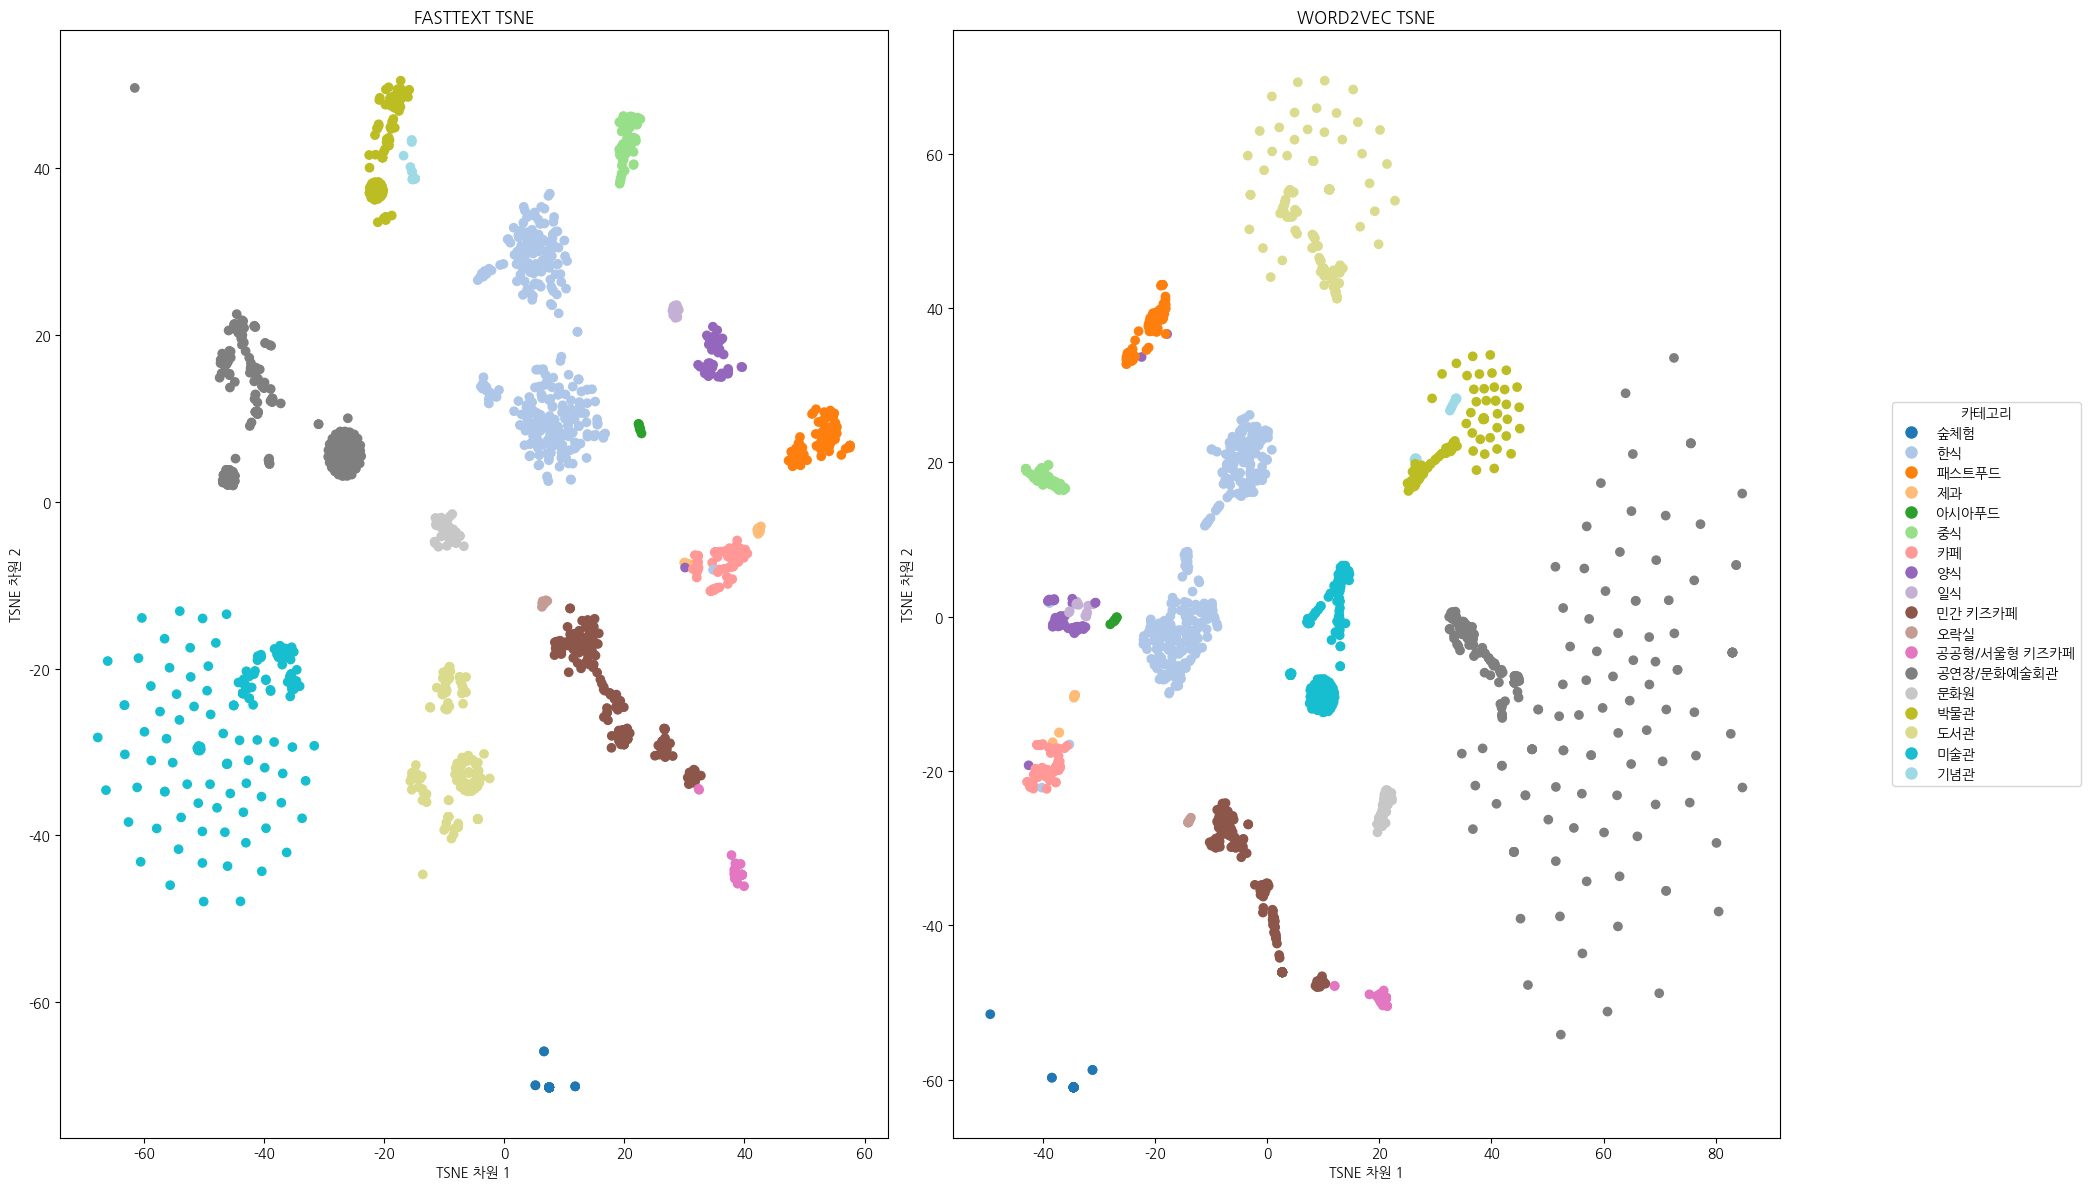

In [20]:
# 데이터셋에 키워드 추출 적용
data['전체키워드_추출'] = data['전체_키워드'].apply(extract_keywords)

sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window = 9, min_count=2, workers=12, sg=1, seed = RANDOM_SEED)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

# input 문장에 대한 가중치 적용 word2vec 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word] * (keyword_weight_value if word in weighted_keywords_list else 1)
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# input 문장에 대한 가중치 적용 fasttext 벡터화 함수 정의
def fasttext_weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        word_vector = model.get_word_vector(word) * (keyword_weight_value if word in weighted_keywords_list else 1)
        word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.get_dimension())
    return np.mean(word_vectors, axis=0)


fasttext_vectors = np.array([fasttext_weight_sentence_to_vector(keywords, ft) for keywords in data['전체키워드_추출']])
word2vec_vectors = np.array([weight_sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])

middle_cate_name = '중분류'

sne = TSNE(n_components=2, random_state=42)


# fasttext tsne
fasttext_tsne = tsne.fit_transform(fasttext_vectors)

# word2vec tsne
word2vec_tsne = tsne.fit_transform(word2vec_vectors)


# 결과를 데이터프레임으로 변환
results = {
    'FASTTEXT TSNE': fasttext_tsne,
    'WORD2VEC TSNE': word2vec_tsne,
}

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# 범주를 숫자로 매핑
unique_categories = data[middle_cate_name].unique()
category_to_num = {category: num for num, category in enumerate(unique_categories)}

num_categories = len(unique_categories)
color_palette = plt.cm.get_cmap('tab20', num_categories)

for i, (title, result) in enumerate(results.items()):
    ax = axes[i]
    
    # 각 데이터프레임에 색상 열 추가
    result_df = pd.DataFrame(result, columns=['x', 'y'])
    result_df[middle_cate_name] = data[middle_cate_name]
    result_df['color'] = result_df[middle_cate_name].map(category_to_num)
    
    scatter = ax.scatter(result_df['x'], result_df['y'], c=result_df['color'], cmap=color_palette)
    ax.set_title(title)
    ax.set_xlabel('TSNE 차원 1')
    ax.set_ylabel('TSNE 차원 2')

# 범례 추가
colors = [color_palette(category_to_num[category]) for category in unique_categories]
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
           for color, category in zip(colors, unique_categories)]
fig.legend(handles=patches, title="카테고리", bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)  # bbox_to_anchor와 loc를 사용하여 범례 위치 조정

# tight_layout 적용
plt.tight_layout()  # 그래프 영역을 줄여서 범례가 들어갈 공간 확보
plt.show()

In [21]:
w2v_acc = w2v_results_df['이진분류 정확도'].mean()
w2v_precision_k = w2v_results_df['Precision@K'].mean()
fasttext_acc = fasttext_results_df['이진분류 정확도'].mean()
fasttext_precision_k = fasttext_results_df['Precision@K'].mean()
kobert_acc = kobert_results_df['이진분류 정확도'].mean()
kobert_precision_k = kobert_results_df['Precision@K'].mean()

print(f"WORD2VEC ({len(w2v_results_df)}) - 이진분류 정확도 : {w2v_acc}, Precision@K : {w2v_precision_k}, test샘플의 대한 소요 시간 : {w2v_finish_time}")
print(f"FASTTEXT ({len(fasttext_results_df)})- 이진분류 정확도 : {fasttext_acc}, Precision@K : {fasttext_precision_k}, test샘플의 대한 소요 시간 : {fasttext_finish_time}")
print(f"KOBERT ({len(kobert_results_df)})- 이진분류 정확도 : {kobert_acc}, Precision@K : {kobert_precision_k}, test샘플의 대한 소요 시간 : {kobert_finish_time}")

WORD2VEC (25) - 이진분류 정확도 : 0.84, Precision@K : 0.664, test샘플의 대한 소요 시간 : 56.11338806152344
FASTTEXT (25)- 이진분류 정확도 : 0.92, Precision@K : 0.7040000000000001, test샘플의 대한 소요 시간 : 67.31611919403076
KOBERT (25)- 이진분류 정확도 : 0.64, Precision@K : 0.064, test샘플의 대한 소요 시간 : 1424.0195665359497


* WORD2VEC, FASTTEXT, KOBERT 임베딩 방식을 고려 하였을 때, 정확도, Precision@K, 소요 시간을 토대로 최종 모델 WORD2VEC를 선정하였다.
> 추가적인 이유는 WORD2VEC의 이진분류 정확도, Precision@K가 FASTTEXT 보다 적다고 판단 되지만, FASTTEXT는 임베딩된 내부 단어들을 통해서, 학습 데이터에 존재하지 않는 단어에 대해서, 벡터를 얻어 불확실한 키워드가 들어왔을시 관련된 단어의 임베딩 값을 올리는 것 모델입니다.
* 따라서, 현재 목표화 된 사용자에게 올바른 정보 추천에 있어서, 잘못된 정보를 줄 가능성이 있다고 판단하여, FASTTEXT를 선택하지 않았습니다.

## EDA

#### 중분류 분포

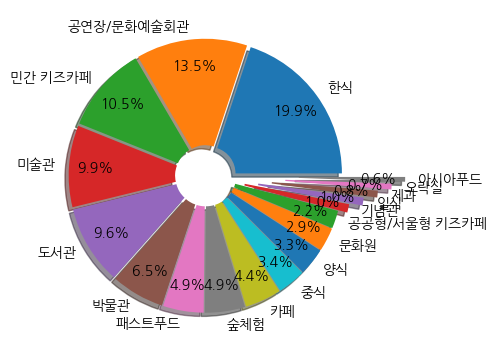

In [17]:
medium_categories_value_counts = data['중분류'].value_counts()
medium_categories_val = medium_categories_value_counts.values
medium_categories_idx = medium_categories_value_counts.index
explode = [0.03] * (len(medium_categories_idx) - 5) + [0.1, 0.2, 0.3, 0.4, 0.5]
total = sum(medium_categories_val)

plt.figure(figsize = (5, 5))
plt.pie(medium_categories_val, labels = medium_categories_idx, autopct = '%.1f%%',
        pctdistance=0.8, explode = explode, shadow = True, wedgeprops = {'width' : 0.8})
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18616\2938110487.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_categories)


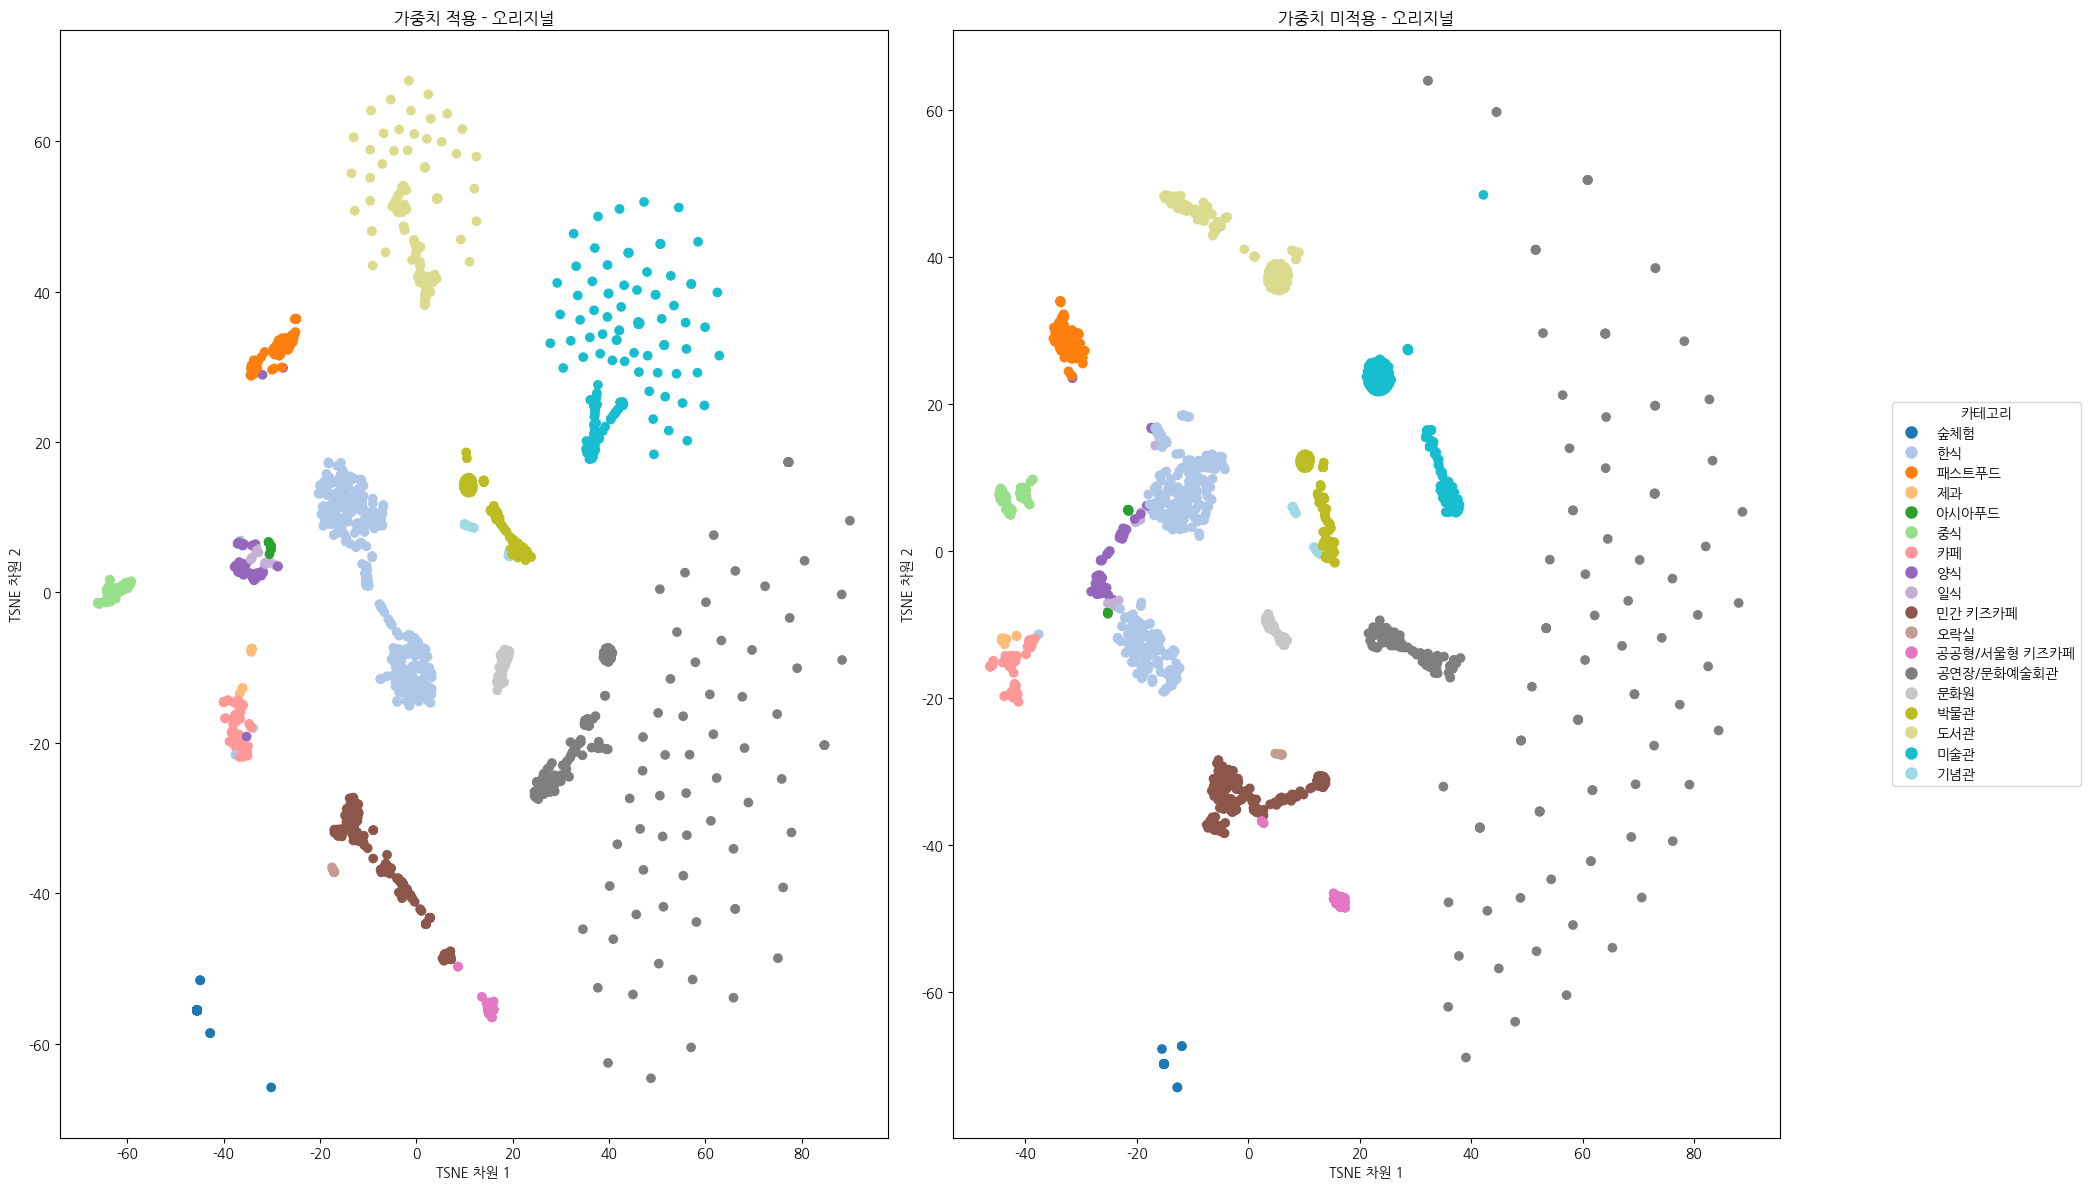

In [19]:
# 데이터셋에 키워드 추출 적용
data['전체키워드_추출'] = data['전체_키워드'].apply(extract_keywords)

sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window = 9, min_count=2, workers=12, sg=1, seed = RANDOM_SEED)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

# input 문장에 대한 가중치 적용 word2vec 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word] * (keyword_weight_value if word in weighted_keywords_list else 1)
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# word2vec 벡터화 함수 정의
def sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word]
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Word2Vec 모델 학습
sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window=9, min_count=2, workers=12, sg=1, seed=RANDOM_SEED)

# 가중치 적용하지 않은 경우의 Word2Vec 벡터화
none_weight_word2vec = np.array([sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])

# 가중치 적용한 경우의 Word2Vec 벡터화
weight_word2vec = np.array([weight_sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])


big_cate_name = '대분류'
middle_cate_name = '중분류'

##################################
tsne = TSNE(n_components=2, random_state=42)


# 가중치 적용 - 오리지널
weight_tsne_results_original = tsne.fit_transform(weight_word2vec)

# 가중치 미적용 - 오리지널
none_weight_tsne_results_original = tsne.fit_transform(none_weight_word2vec)


# 결과를 데이터프레임으로 변환
results = {
    '가중치 적용 - 오리지널': weight_tsne_results_original,
    '가중치 미적용 - 오리지널': none_weight_tsne_results_original,
}

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# 범주를 숫자로 매핑
unique_categories = data[middle_cate_name].unique()
category_to_num = {category: num for num, category in enumerate(unique_categories)}

num_categories = len(unique_categories)
color_palette = plt.cm.get_cmap('tab20', num_categories)

for i, (title, result) in enumerate(results.items()):
    ax = axes[i]
    
    # 각 데이터프레임에 색상 열 추가
    result_df = pd.DataFrame(result, columns=['x', 'y'])
    result_df[middle_cate_name] = data[middle_cate_name]
    result_df['color'] = result_df[middle_cate_name].map(category_to_num)
    
    scatter = ax.scatter(result_df['x'], result_df['y'], c=result_df['color'], cmap=color_palette)
    ax.set_title(title)
    ax.set_xlabel('TSNE 차원 1')
    ax.set_ylabel('TSNE 차원 2')

# 범례 추가
colors = [color_palette(category_to_num[category]) for category in unique_categories]
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
           for color, category in zip(colors, unique_categories)]
fig.legend(handles=patches, title="카테고리", bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)  # bbox_to_anchor와 loc를 사용하여 범례 위치 조정

# tight_layout 적용
plt.tight_layout()  # 그래프 영역을 줄여서 범례가 들어갈 공간 확보
plt.show()

#### 대분류 분포

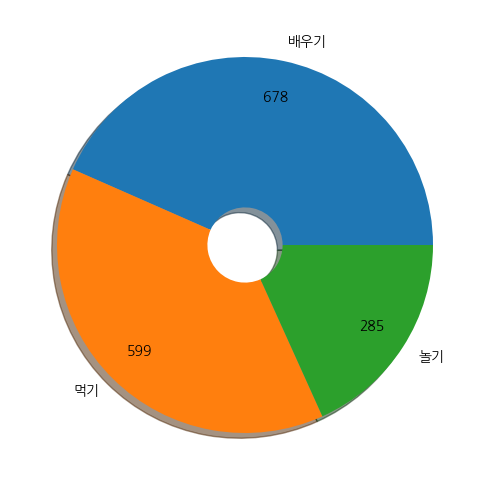

In [22]:
large_categories_value_counts = data['대분류'].value_counts()
large_categories_value_counts_val = large_categories_value_counts.values
large_categories_value_counts_idx = large_categories_value_counts.index
total = sum(large_categories_value_counts_val)

plt.figure(figsize = (5, 5))
plt.pie(large_categories_value_counts_val, labels = large_categories_value_counts_idx, autopct = lambda x: '{:.0f}'.format(x * total / 100),
        pctdistance=0.8, shadow = True, wedgeprops = {'width' : 0.8})
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_18616\418819157.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_categories)


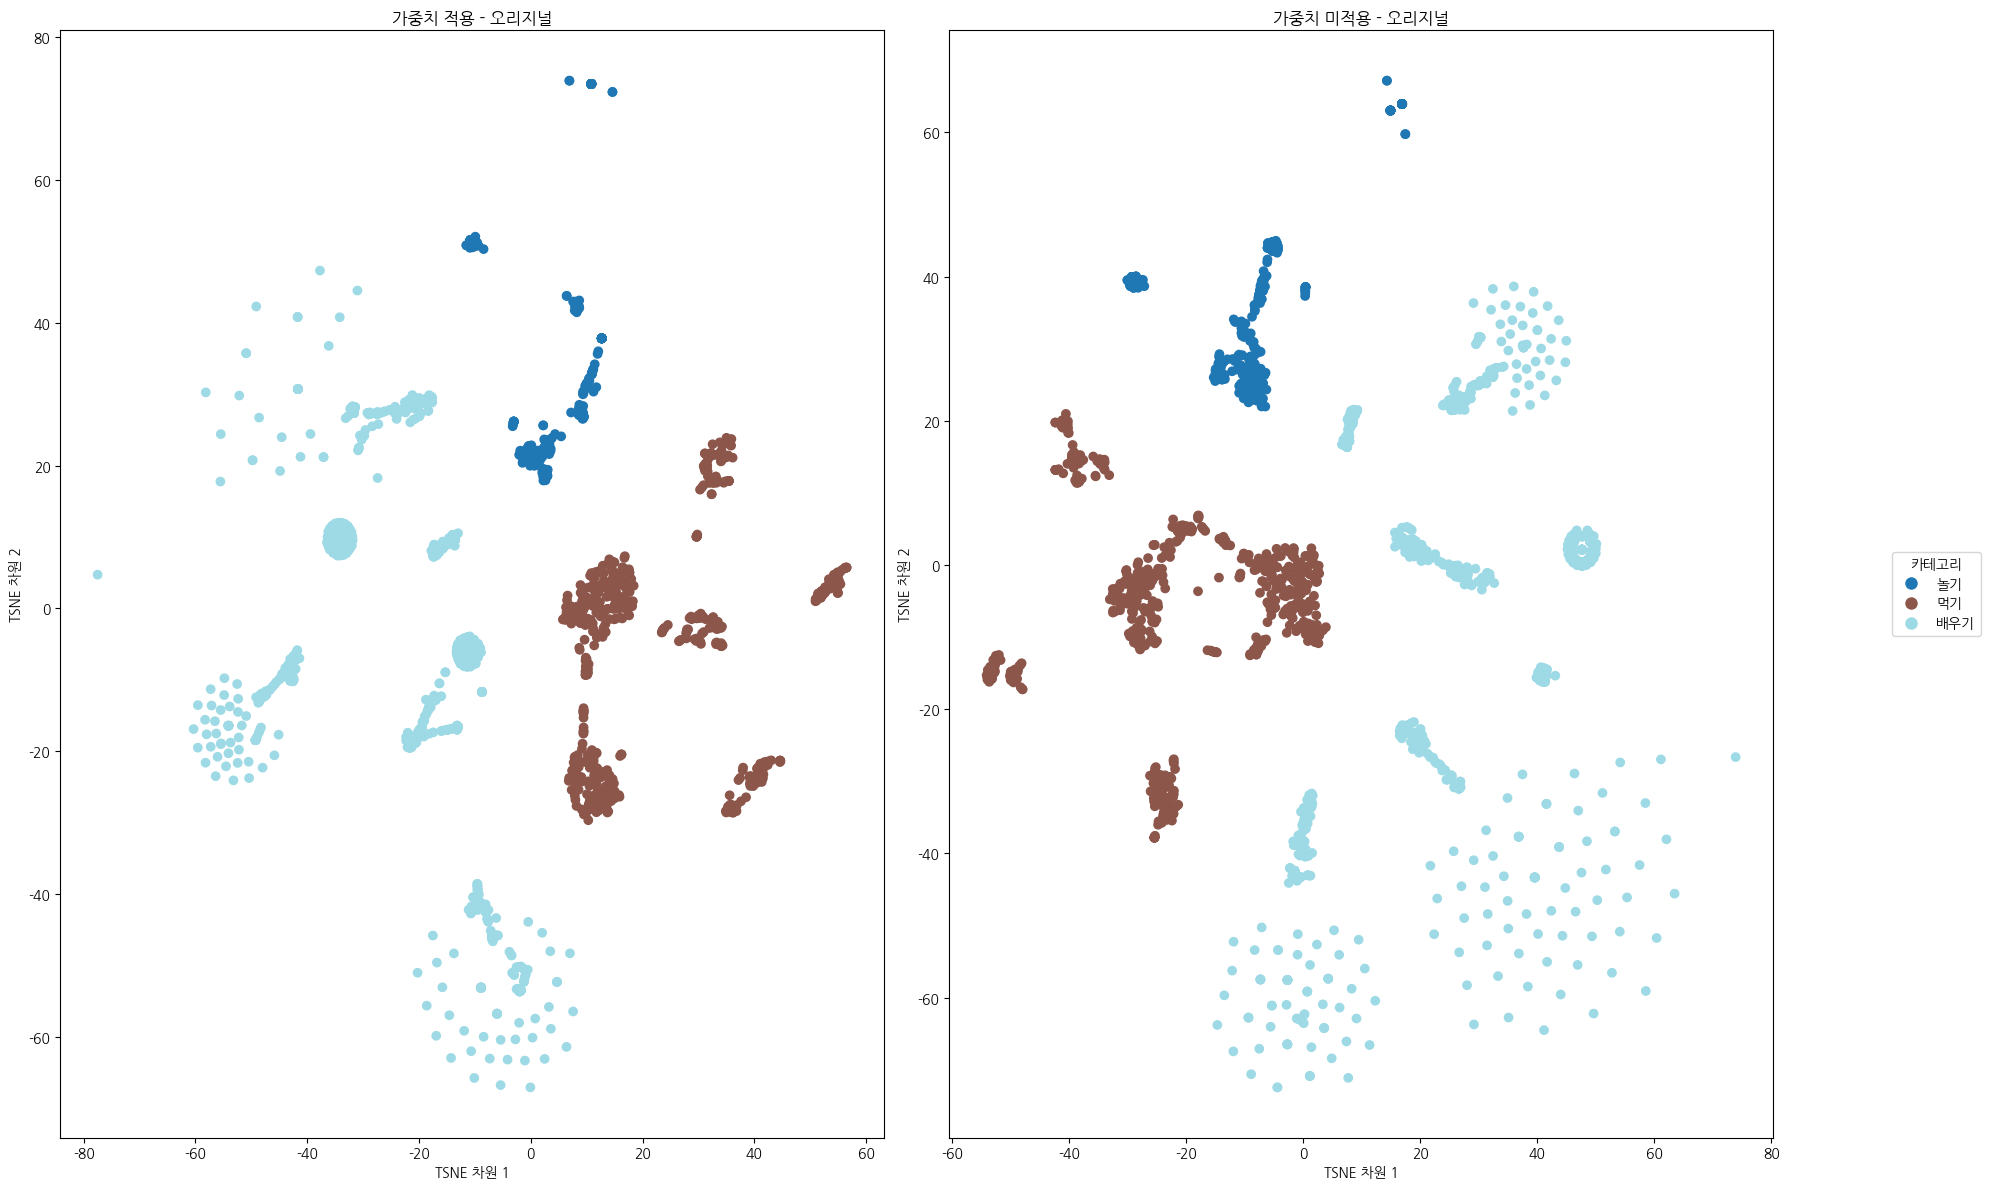

In [23]:
# 데이터셋에 키워드 추출 적용
data['전체키워드_추출'] = data['전체_키워드'].apply(extract_keywords)

sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window = 9, min_count=2, workers=12, sg=1, seed = RANDOM_SEED)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

# input 문장에 대한 가중치 적용 word2vec 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word] * (keyword_weight_value if word in weighted_keywords_list else 1)
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# word2vec 벡터화 함수 정의
def sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word]
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Word2Vec 모델 학습
sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window=9, min_count=2, workers=12, sg=1, seed=RANDOM_SEED)

# 가중치 적용하지 않은 경우의 Word2Vec 벡터화
none_weight_word2vec = np.array([sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])

# 가중치 적용한 경우의 Word2Vec 벡터화
weight_word2vec = np.array([weight_sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])


big_cate_name = '대분류'
middle_cate_name = '중분류'

##################################
tsne = TSNE(n_components=2, random_state=42)


# 가중치 적용 - 오리지널, Random Oversampling, SMOTE
weight_tsne_results_original = tsne.fit_transform(weight_word2vec)

# 가중치 미적용 - 오리지널, Random Oversampling, SMOTE
none_weight_tsne_results_original = tsne.fit_transform(none_weight_word2vec)

# 결과를 데이터프레임으로 변환
results = {
    '가중치 적용 - 오리지널': weight_tsne_results_original,
    '가중치 미적용 - 오리지널': none_weight_tsne_results_original,
}

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# 범주를 숫자로 매핑
unique_categories = data[big_cate_name].unique()
category_to_num = {category: num for num, category in enumerate(unique_categories)}

num_categories = len(unique_categories)
color_palette = plt.cm.get_cmap('tab20', num_categories)

for i, (title, result) in enumerate(results.items()):
    ax = axes[i]
    
    # 각 데이터프레임에 색상 열 추가
    result_df = pd.DataFrame(result, columns=['x', 'y'])
    result_df[big_cate_name] = data[big_cate_name]
    result_df['color'] = result_df[big_cate_name].map(category_to_num)
    
    scatter = ax.scatter(result_df['x'], result_df['y'], c=result_df['color'], cmap=color_palette)
    ax.set_title(title)
    ax.set_xlabel('TSNE 차원 1')
    ax.set_ylabel('TSNE 차원 2')

# 범례 추가
colors = [color_palette(category_to_num[category]) for category in unique_categories]
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
           for color, category in zip(colors, unique_categories)]
fig.legend(handles=patches, title="카테고리", bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)  # bbox_to_anchor와 loc를 사용하여 범례 위치 조정

# tight_layout 적용
plt.tight_layout()  # 그래프 영역을 줄여서 범례가 들어갈 공간 확보
plt.show()

##### 이진분류 분포

C:\Users\User\AppData\Local\Temp\ipykernel_18616\166193831.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_categories)


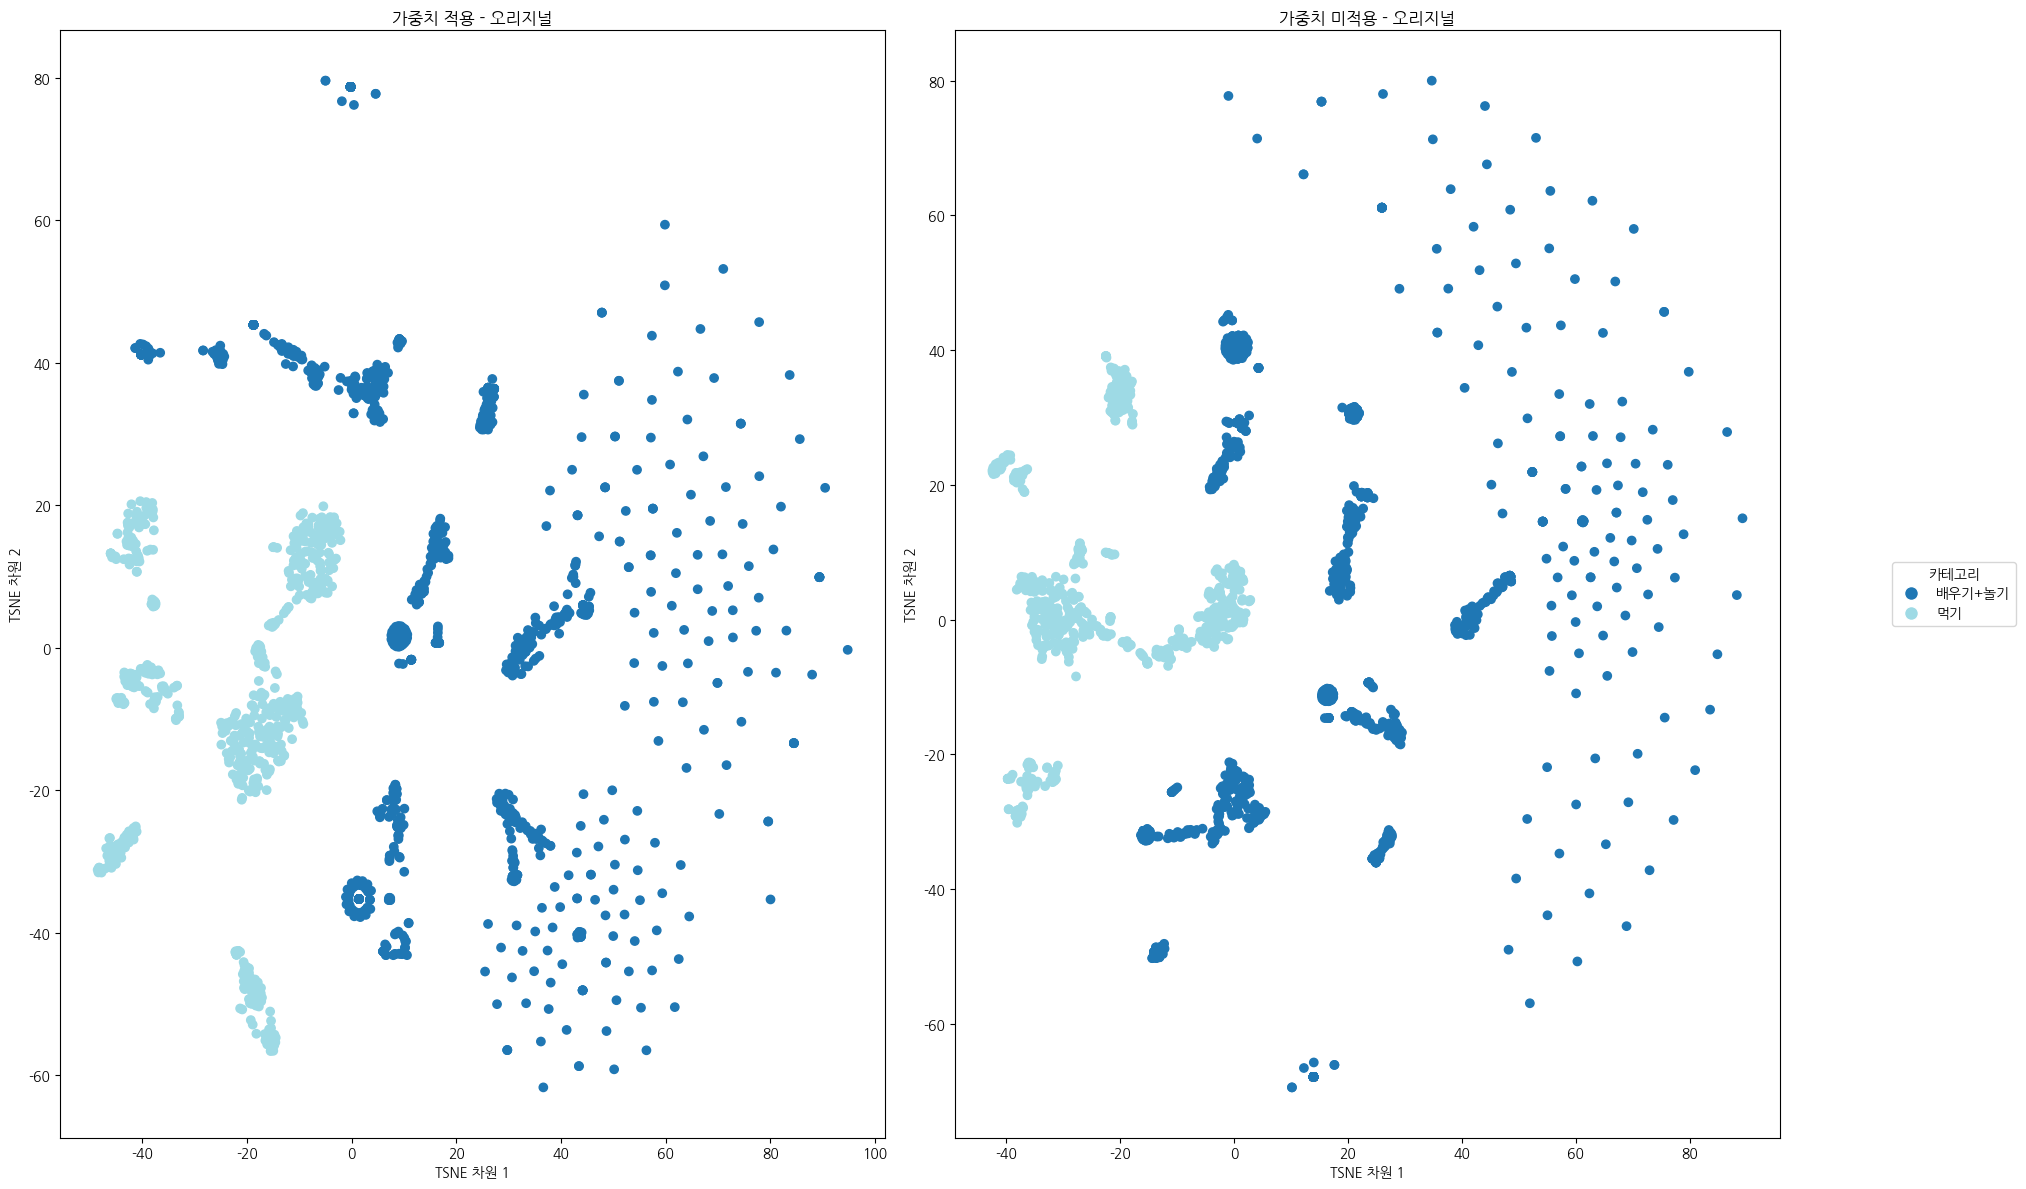

In [24]:
# 데이터셋에 키워드 추출 적용
data['전체키워드_추출'] = data['전체_키워드'].apply(extract_keywords)

sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window = 9, min_count=2, workers=12, sg=1, seed = RANDOM_SEED)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

# input 문장에 대한 가중치 적용 word2vec 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word] * (keyword_weight_value if word in weighted_keywords_list else 1)
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# word2vec 벡터화 함수 정의
def sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word]
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Word2Vec 모델 학습
sentences = data['전체키워드_추출'].tolist()
total_W2V_MODEL = Word2Vec(sentences, vector_size=300, window=9, min_count=2, workers=12, sg=1, seed=RANDOM_SEED)

# 가중치 적용하지 않은 경우의 Word2Vec 벡터화
none_weight_word2vec = np.array([sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])

# 가중치 적용한 경우의 Word2Vec 벡터화
weight_word2vec = np.array([weight_sentence_to_vector(keywords, total_W2V_MODEL) for keywords in data['전체키워드_추출']])

data['먹기_먹기X'] = data['대분류'].map(lambda x: '먹기' if x == '먹기' else '배우기+놀기')

big_cate_name = '대분류'
middle_cate_name = '중분류'
binary_cate_name = '먹기_먹기X'

##################################
tsne = TSNE(n_components=2, random_state=42)


# 가중치 적용 - 오리지널, Random Oversampling, SMOTE
weight_tsne_results_original = tsne.fit_transform(weight_word2vec)

# 가중치 미적용 - 오리지널, Random Oversampling, SMOTE
none_weight_tsne_results_original = tsne.fit_transform(none_weight_word2vec)

# 결과를 데이터프레임으로 변환
results = {
    '가중치 적용 - 오리지널': weight_tsne_results_original,
    '가중치 미적용 - 오리지널': none_weight_tsne_results_original,
}

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# 범주를 숫자로 매핑
unique_categories = data[binary_cate_name].unique()
category_to_num = {category: num for num, category in enumerate(unique_categories)}

num_categories = len(unique_categories)
color_palette = plt.cm.get_cmap('tab20', num_categories)

for i, (title, result) in enumerate(results.items()):
    ax = axes[i]
    
    # 각 데이터프레임에 색상 열 추가
    result_df = pd.DataFrame(result, columns=['x', 'y'])
    result_df[binary_cate_name] = data[binary_cate_name]
    result_df['color'] = result_df[binary_cate_name].map(category_to_num)
    
    scatter = ax.scatter(result_df['x'], result_df['y'], c=result_df['color'], cmap=color_palette)
    ax.set_title(title)
    ax.set_xlabel('TSNE 차원 1')
    ax.set_ylabel('TSNE 차원 2')

# 범례 추가
colors = [color_palette(category_to_num[category]) for category in unique_categories]
patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) 
           for color, category in zip(colors, unique_categories)]
fig.legend(handles=patches, title="카테고리", bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)  # bbox_to_anchor와 loc를 사용하여 범례 위치 조정

# tight_layout 적용
plt.tight_layout()  # 그래프 영역을 줄여서 범례가 들어갈 공간 확보
plt.show()